<a href="https://colab.research.google.com/github/mdaipayan/BE-Project-Template/blob/main/DSM_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Truss to solve

Click here and upload image file figure of the truss to solve

 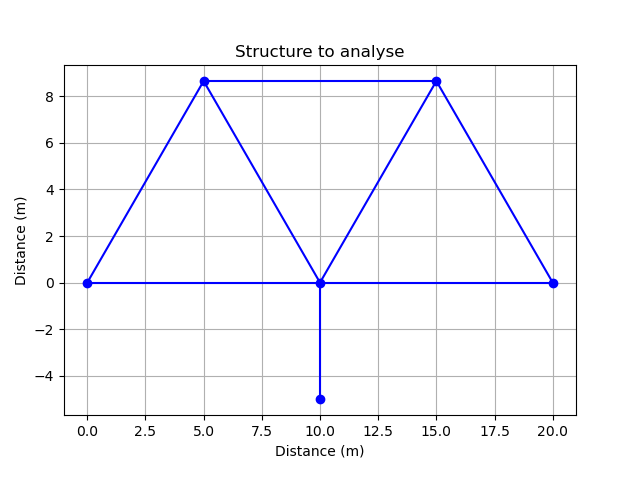

# Program Initialization

Program Starts form below

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Module installation 
!pip install python-docx

In [ ]:

'''
This is program prepared by D Mandal dated 17 April 2021
meant to solve 2D truss by using Driect Stiffnes Method
'''

# CALLING PYTHON PACKAGES
import copy
import math

import prompt_toolkit
from docx import Document
import matplotlib.pyplot as plt
import numpy as np
import os





# Load Given Data

In [ ]:

# function to label member number
def text(x, y, txt):
    t = axes.text(x, y, txt, backgroundcolor="white",
                  ha='center', va='top', weight='bold', color='red', alpha=1)
    t.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='white'))


# function to label node number
def text2(x, y, txt):
    t = axes.text(x, y, txt, backgroundcolor="white",
                  ha='center', va='top', weight='bold', color='green', alpha=1)
    t.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='white'))


# DEFINE INPUT DATA
# open material properties file and take E and A value
file1 = open('/content/drive/MyDrive/Colab Notebooks/material_properties.txt', 'r')
E = int(file1.readline())
A = float(file1.readline())
xFac = 200

# open nodes file and take x and y co-ordinates of the nodes
nodes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/nodes.txt', dtype=float)

# open member file and take node i and node j numbers
members = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/member.txt', dtype=int)

# open support file and take restrained degree of freedom
restrainedDOF = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/restrained.txt', dtype=int)

# open load file and take loading data
forceVector = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/load.txt', dtype=int)

# PLOT THE TRUSS
fig = plt.figure(figsize=(6,6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# fig.gca().set_aspect('equal', adjustable='box')
i = 0

# annotate node numbers
for j in range(len(nodes)):
    text2(nodes[j, 0] + 0.2, nodes[j, 1] + 0.25, j + 1)

# plot members

for mbr in members:
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    ix = nodes[node_i - 1, 0]  # x-coord of node i of this member
    iy = nodes[node_i - 1, 1]  # y-coord of node i of this member
    jx = nodes[node_j - 1, 0]  # x-coord of node j of this member
    jy = nodes[node_j - 1, 1]  # y-coord of node j of this member

    # annotate member number
    i = i + 1
     
    text(((ix + jx) /2) + .25, ((iy + jy) /2), i) 
   
     
    
    # Index of DoF for this member
    ia = 2 * node_i - 2  # horizontal DoF at node i of this member
    ib = 2 * node_i - 1  # vertical DoF at node i of this member
    ja = 2 * node_j - 2  # horizontal DoF at node j of this member
    jb = 2 * node_j - 1  # vertical DoF at node j of this member

    axes.plot([ix, jx], [iy, jy], 'b')  # Member

# Plot nodes
for node in nodes:
    axes.plot([node[0]], [node[1]], 'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Truss to analyse')
axes.grid()
plt.savefig("structure.png")
plt.show()

# Calculation

In [ ]:
# define a function to calculate member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo - 1  # Index identifying member in array of members
    node_i = members[memberIndex][0]  # Node number for node i of this member
    node_j = members[memberIndex][1]  # Node number for node j of this member

    xi = nodes[node_i - 1][0]  # x-coord for node i
    yi = nodes[node_i - 1][1]  # y-coord for node i
    xj = nodes[node_j - 1][0]  # x-coord for node j
    yj = nodes[node_j - 1][1]  # y-coord for node j

    # Angle of member with respect to horizontal axis

    dx = xj - xi  # x-component of vector along member
    dy = yj - yi  # y-component of vector along member
    mag = math.sqrt(dx ** 2 + dy ** 2)  # Magnitude of vector (length of member)
    memberVector = np.array([dx, dy])  # Member represented as a vector

    # Need to capture quadrant first then appropriate reference axis and offset angle
    if (dx > 0 and dy == 0):
        theta = 0
    elif (dx == 0 and dy > 0):
        theta = math.pi / 2
    elif (dx < 0 and dy == 0):
        theta = math.pi
    elif (dx == 0 and dy < 0):
        theta = 3 * math.pi / 2
    elif (dx > 0 and dy > 0):
        # 0<theta<90
        refVector = np.array([1, 0])  # Vector describing the positive x-axis
        theta = math.acos(
            refVector.dot(memberVector) / (mag))  # Standard formula for the angle between two vectors
    elif (dx < 0 and dy > 0):
        # 90<theta<180
        refVector = np.array([0, 1])  # Vector describing the positive y-axis
        theta = (math.pi / 2) + math.acos(
            refVector.dot(memberVector) / (mag))  # Standard formula for the angle between two vectors
    elif (dx < 0 and dy < 0):
        # 180<theta<270
        refVector = np.array([-1, 0])  # Vector describing the negative x-axis
        theta = math.pi + math.acos(
            refVector.dot(memberVector) / (mag))  # Standard formula for the angle between two vectors
    else:
        # 270<theta<360
        refVector = np.array([0, -1])  # Vector describing the negative y-axis
        theta = (3 * math.pi / 2) + math.acos(
            refVector.dot(memberVector) / (mag))  # Standard formula for the angle between two vectors

    return [theta, mag]


# Calculate orientation and length for each member and store
orientations = np.array([])  # Initialise an array to hold orientations
lengths = np.array([])  # Initialise an array to hold lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n + 1)
    orientations = np.append(orientations, angle)
    lengths = np.append(lengths, length)

# Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number
    """
    theta = orientations[memberNo - 1]
    mag = lengths[memberNo - 1]

    c = math.cos(theta)
    s = math.sin(theta)

    K11 = (E * A / mag) * np.array([[c ** 2, c * s], [c * s, s ** 2]])  # Top left quadrant of global stiffness matrix
    K12 = (E * A / mag) * np.array(
        [[-c ** 2, -c * s], [-c * s, -s ** 2]])  # Top right quadrant of global stiffness matrix
    K21 = (E * A / mag) * np.array(
        [[-c ** 2, -c * s], [-c * s, -s ** 2]])  # Bottom left quadrant of global stiffness matrix
    K22 = (E * A / mag) * np.array(
        [[c ** 2, c * s], [c * s, s ** 2]])  # Bottom right quadrant of global stiffness matrix

    return [K11, K12, K21, K22]


nDoF = len(nodes) * 2  # Total number of degrees of freedom in the problem

Kp = np.zeros([nDoF, nDoF])  # Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
    # note that enumerate adds a counter to an iterable (n)

    # Calculate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21, K22] = calculateKg(n + 1)

    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    # Primary stiffness matrix indices associated with each node
    # i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
    ia = 2 * node_i - 2  # index 0
    ib = 2 * node_i - 1  # index 1
    ja = 2 * node_j - 2  # index 2
    jb = 2 * node_j - 1  # index 3
    Kp[ia:ib + 1, ia:ib + 1] = Kp[ia:ib + 1, ia:ib + 1] + K11
    Kp[ia:ib + 1, ja:jb + 1] = Kp[ia:ib + 1, ja:jb + 1] + K12
    Kp[ja:jb + 1, ia:ib + 1] = Kp[ja:jb + 1, ia:ib + 1] + K21
    Kp[ja:jb + 1, ja:jb + 1] = Kp[ja:jb + 1, ja:jb + 1] + K22

restrainedIndex = [x - 1 for x in restrainedDOF]  # Index for each restrained DoF (list comprehension)

# Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp, restrainedIndex, 0)  # Delete rows
Ks = np.delete(Ks, restrainedIndex, 1)  # Delete columns
Ks = np.matrix(Ks)  # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

forceVectorRed = copy.copy(
    forceVector)  # Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed, restrainedIndex, 0)  # Delete rows corresponding to restrained DoF

u = Ks.I.dot(forceVectorRed)
U = u.T

# Construct the global displacement vector
UG = np.zeros(nDoF)  # Initialise an array to hold the global displacement vector
c = 0  # Initialise a counter to track how many restraints have been imposed

for i in np.arange(nDoF):
    if i in restrainedIndex:
        # Impose zero displacement
        UG[i] = 0
    else:
        # Assign actual displacement
        UG[i] = U[c]
        c = c + 1

UG = np.array([UG]).T
FG = np.matmul(Kp, UG)

mbrForces = np.array([])  # Initialise an array to hold member forces
for n, mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member
    # Primary stiffness matrix indices associated with each node
    ia = 2 * node_i - 2
    ib = 2 * node_i - 1
    ja = 2 * node_j - 2
    jb = 2 * node_j - 1

    # Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c, s, 0, 0], [0, 0, c, s]])

    disp = np.array([[UG[ia], UG[ib], UG[ja], UG[jb]]]).T  # Global displacements
    disp_local = np.matmul(T, disp)[0]  # Local displacements
    F_axial = (A * E / mag) * (disp_local[1] - disp_local[0])  # Axial loads
    mbrForces = np.append(mbrForces, F_axial)  # Store axial loads

# PLOT DEFLECTED SHAPE
fig = plt.figure(figsize=(6,6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])


# Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0]  # Node number for node i of this member
    node_j = mbr[1]  # Node number for node j of this member

    ix = nodes[node_i - 1, 0]  # x-coord of node i of this member
    iy = nodes[node_i - 1, 1]  # y-coord of node i of this member
    jx = nodes[node_j - 1, 0]  # x-coord of node j of this member
    jy = nodes[node_j - 1, 1]  # y-coord of node j of this member

    
    # Index of DoF for this member
    ia = 2 * node_i - 2  # horizontal DoF at node i of this member
    ib = 2 * node_i - 1  # vertical DoF at node i of this member
    ja = 2 * node_j - 2  # horizontal DoF at node j of this member
    jb = 2 * node_j - 1  # vertical DoF at node j of this member

    axes.plot([ix, jx], [iy, jy], 'b')  # Member
    axes.plot([ix + UG[ia, 0] * xFac, jx + UG[ja, 0] * xFac], [iy + UG[ib, 0] * xFac, jy + UG[jb, 0] * xFac],
              '--r')  # Deformed member

# Plot nodes
for node in nodes:
    axes.plot([node[0]], [node[1]], 'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.savefig("structure2.png")
plt.show()

# Output Documentation

In [ ]:
# WRITING OUT IN WORD FILE

document = Document()
document.add_heading('Truss Analysis Report Using Python', 0)

document.add_picture('structure.png')

document.add_heading('Reactions (+ve upward/right, -ve downwards/left)', level=1)
document.styles['Normal'].font.name = 'Arial'
for i in np.arange(0, len(restrainedIndex)):
    index = restrainedIndex[i]
    document.add_paragraph('Reaction at DoF ' + str(index + 1) + ' : ' + str(round(FG[index].item() / 1000, 2)) + ' kN')

document.add_heading('Member Forces (+ve Compression, -ve Tension)', level=1)
for n, mbr in enumerate(members):
    document.add_paragraph('Force in member ' + str(n + 1) + ' : ' + str(round(mbrForces[n] / 1000, 2)) + ' kN')

document.add_heading('Nodal Displacements (+ve upward, -ve downwards)', level=1)
for n, node in enumerate(nodes):
    ix = 2 * (n + 1) - 2  # horizontal DoF for this node
    iy = 2 * (n + 1) - 1  # vertical DoF for this node

    ux = round(UG[ix, 0], 5)  # Horizontal nodal displacement
    uy = round(UG[iy, 0], 5)  # Vertical nodal displacement
    document.add_paragraph('Node ' + str(n + 1) + ' : ' + 'Ux = ' + str(ux) + ' m,' + 'Uy = ' + str(uy) + ' m')

document.add_picture('structure2.png')
document.add_heading('Prepared by D Mandal', 2)
document.save('Result.docx')




Download your result document from temporary folder at side bar